In [98]:
import os
import json

import dgl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import torch

In [35]:
experiments = [
    'gat_x1',
    'gatv2_x1',
    'joint_x1',
    'joint_roberta_x1',
    'joint_roberta_x1_lr3.5',
    'joint_twitter_roberta_x1',
    'joint_twitter_roberta_x1_lr3.5',
    'jointv2_x1',
    'jointv2_roberta_x1',
    'jointv2_roberta_x1_lr3.5',
    'joint_x10',
    'jointv2_x10',
]

labels = [
    'GAT',
    'GATv2',
    'GAT+Bert',
    'GAT+RoBERTa\n (lr=5.5e-5)',
    'GAT+RoBERTa\n (lr=3.5e-5)',
    'GAT+TwitterRoBERTa\n (lr=5.5e-5)',
    'GAT+TwitterRoBERTa\n (lr=3.5e-5)',
    'GATv2+BERT',
    'GATv2+RoBERTa\n (lr=5e-5)',
    'GATv2+RoBERTa\n (lr=3.5e-5)',
    'GAT+BERT',
    'GATv2+BERT'
]

assert(len(experiments) == len(labels))

baseline = ['joint_x10']
final_results = []

## Plotting for training and test metrics

In [15]:
data_x1 = []
data_x10 = []

for _, experiment in enumerate(experiments):
    print(f"Pulling data for experiment {experiment}...")
    file_path = f"../results/{experiment}_metrics.json"
    f = open(file_path)
    data = json.load(f)
    f.close()
    data = [*data.values()]
    if len(data) == 1:
        d_x1 = data[0]
        # print(data)
        d_x1 = {k:v for k,v in d_x1.items() if type(v) is list and len(v) > 0}
        data_x1.append(pd.DataFrame.from_dict(d_x1))
    else:
        d_x10 = [{k:v for k,v in d.items() if type(v) is list and len(v) > 0} for d in data]
        data_x10.append([pd.DataFrame.from_dict(d) for d in d_x10])
print(len(data_x1))
print(len(data_x10))

Pulling data for experiment gat_x1...
Pulling data for experiment gatv2_x1...
Pulling data for experiment joint_x1...
Pulling data for experiment joint_roberta_x1...
Pulling data for experiment joint_roberta_x1_lr3.5...
Pulling data for experiment joint_twitter_roberta_x1...
Pulling data for experiment joint_twitter_roberta_x1_lr3.5...
Pulling data for experiment jointv2_x1...
Pulling data for experiment jointv2_roberta_x1...
Pulling data for experiment jointv2_roberta_x1_lr3.5...
Pulling data for experiment joint_x10...
Pulling data for experiment jointv2_x10...
10
2


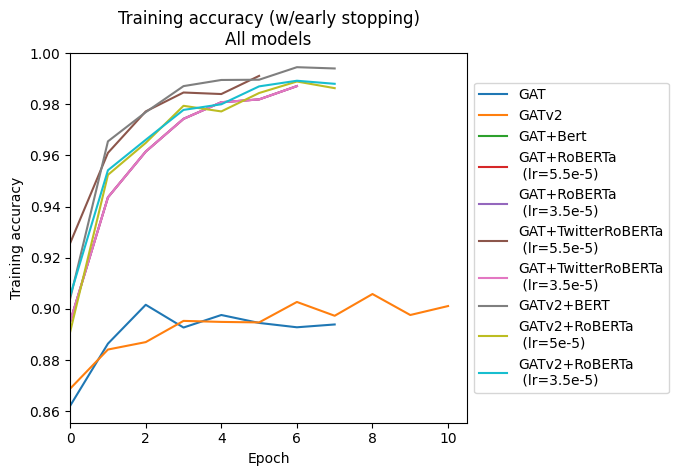

In [39]:
fig = plt.figure()
ax = plt.subplot(111)

sample = experiments[0:10]

for idx, experiment in enumerate(sample):
    d = data_x1[0:10][idx].train_acc
    ax.plot(d, label=labels[0:10][idx])

box =ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Epoch')
ax.set_xlim(0.0)
ax.set_ylabel('Training accuracy')
ax.set_ylim(top=1.0)
ax.set_title("Training accuracy (w/early stopping)\nAll models")

plt.savefig("../publish/images/training_acc_all.png", dpi=300)
plt.show()

## Graph Attention Heatmap

```
    def attention_per_edge(self, example):
        logits, (edge_index, alpha) = self.forward(example, return_attention_weights=True)
        _, pred = logits.max(dim=1)

        return pred, alpha.cpu().detach().numpy(), edge_index.cpu().detach().numpy()
```

Code based on https://github.com/tech-srl/how_attentive_are_gats/blob/main/dictionary_lookup/experiment.py

In [50]:
import sys
sys.path.append(os.path.abspath('../'))

In [51]:
from dataloaders.graph_data import load_graph
from models.joint import GATV2

gatv2_path = os.path.join('../saved_models', 'gatv2_0_best.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(gatv2_path, map_location=device)

tweet_path = '../data/tweets.csv'
user_path = '../data/users.csv'
relationship_path = '../data/relationships.csv'
ts = 0.3
fm = 'soft'
fi = 'non_off'
num_labels = 2
args = dict()
args['hidden_size'] = 768

g, _, _, _ = load_graph(tweet_path, user_path, relationship_path, test_size=ts, feat_model=fm, feat_init=fi)
g = g.to(device)
features = g.ndata['features']
features_size = features.size()[1]
model = GATV2(fs=features_size, model_size=None, args=args, num_labels=num_labels)

model.load_state_dict(checkpoint['model_state_dict'])

Graph(num_nodes=1260, num_edges=10137,
      ndata_schemes={'features': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})


<All keys matched successfully>

In [68]:
print(model)

GATV2(
  (gat): GATv2Layer(
    (layer1): GATv2Conv(
      (fc_src): Linear(in_features=2, out_features=6144, bias=True)
      (fc_dst): Linear(in_features=2, out_features=6144, bias=True)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=2, out_features=6144, bias=True)
    )
  )
  (layer_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (slf_attn): MultiHeadAttention(
    (w_qs): Linear(in_features=768, out_features=512, bias=False)
    (w_ks): Linear(in_features=768, out_features=512, bias=False)
    (w_vs): Linear(in_features=768, out_features=512, bias=False)
    (fc): Linear(in_features=512, out_features=768, bias=False)
    (attention): ScaledDotProductAttention(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layer_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  )
 

In [88]:
model.slf_attn.w_qs

Linear(in_features=768, out_features=512, bias=False)

In [91]:
def visualize_graph(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=50, cmap=plt.get_cmap('coolwarm'), node_color=labels, edge_color='k',arrows=False, width=0.5, style='dotted', with_labels=False)


/run/media/cprimel/Data/cs6953-dl/graph-fusion-old/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


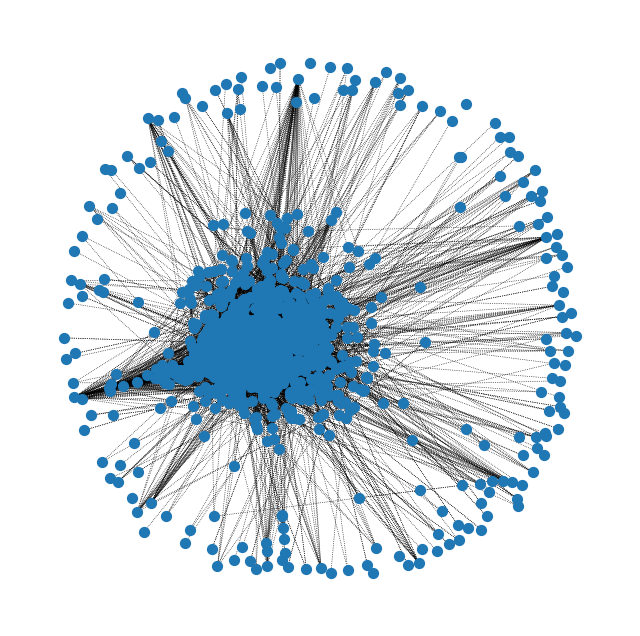

In [99]:
g = dgl.remove_self_loop(g)

nx_g = g.cpu().to_networkx()

visualize_graph(None, nx_g)

In [100]:
g.edata

{}